In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import time
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image
import pathlib
from pathlib import Path
import pandas as pd

import monai
from monai.apps import download_and_extract
from monai.config import print_config

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [2]:
SEED = 1380
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
class FMRIConnectivityDataset(Dataset):
    def __init__(self, data_directory, ids, transform=None):
        self.transform = transform
        self.data = [] 

        for subject_id in ids:
            rest_file_path = os.path.join(data_directory, f"{subject_id}_rfMRI_REST1_LR.csv")
            motor_file_path = os.path.join(data_directory, f"{subject_id}_tfMRI_MOTOR_LR.csv")

            if os.path.exists(rest_file_path) and os.path.exists(motor_file_path):
                rest_data = pd.read_csv(rest_file_path)
                motor_data = pd.read_csv(motor_file_path)

                self.data.append((subject_id, rest_data.values, motor_data.values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id, rest_fMRI_matrix, motor_task_fMRI_matrix = self.data[idx]

        data_dict = {
            "subject_id": subject_id,
            "rest_fMRI_data": torch.FloatTensor(rest_fMRI_matrix[np.newaxis,:,:]),
            "motor_task_fMRI_data": torch.FloatTensor(motor_task_fMRI_matrix[np.newaxis,:,:])
        }

        return data_dict

In [4]:
data_directory = "Data/hcp_rest_and_motor/"

# List all files in the data directory
file_names = [f for f in os.listdir(data_directory) if f.endswith(".csv")]

# Split the file names to extract the subject IDs
file_ids = [file.split('_')[0] for file in file_names]

# Define the split ratios (60% train, 20% validation, 20% test)
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Split the subject IDs into train, validation, and test sets
train_ids, test_and_val_ids = train_test_split(file_ids, test_size=test_ratio, random_state=1380)
validation_ids, test_ids = train_test_split(test_and_val_ids, test_size=0.5, random_state=1380)

# Create datasets for the training, validation, and test sets
train_dataset = FMRIConnectivityDataset(data_directory, train_ids)
validation_dataset = FMRIConnectivityDataset(data_directory, validation_ids)
test_dataset = FMRIConnectivityDataset(data_directory, test_ids)

# Dataloaders for training, validation, and test sets
batch_size = 3
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import random

def sample_fMRI_data(data_loader):
    """
    Sample a batch of fMRI data containing both X (rest) and Y (motor) from a DataLoader.
    
    Args:
        data_loader (DataLoader): The DataLoader for the fMRI dataset.

    Returns:
        tuple of torch.Tensor: A tuple containing X (resting state data) and Y (motor task data).
    """
    batch = next(iter(data_loader))
    X = batch["rest_fMRI_data"]
    Y = batch["motor_task_fMRI_data"]

    return X, Y

# Example usage in the training loop
X, Y = sample_fMRI_data(train_data_loader)

In [6]:
X.shape

torch.Size([3, 1, 400, 400])

In [7]:
Y.shape

torch.Size([3, 1, 400, 400])

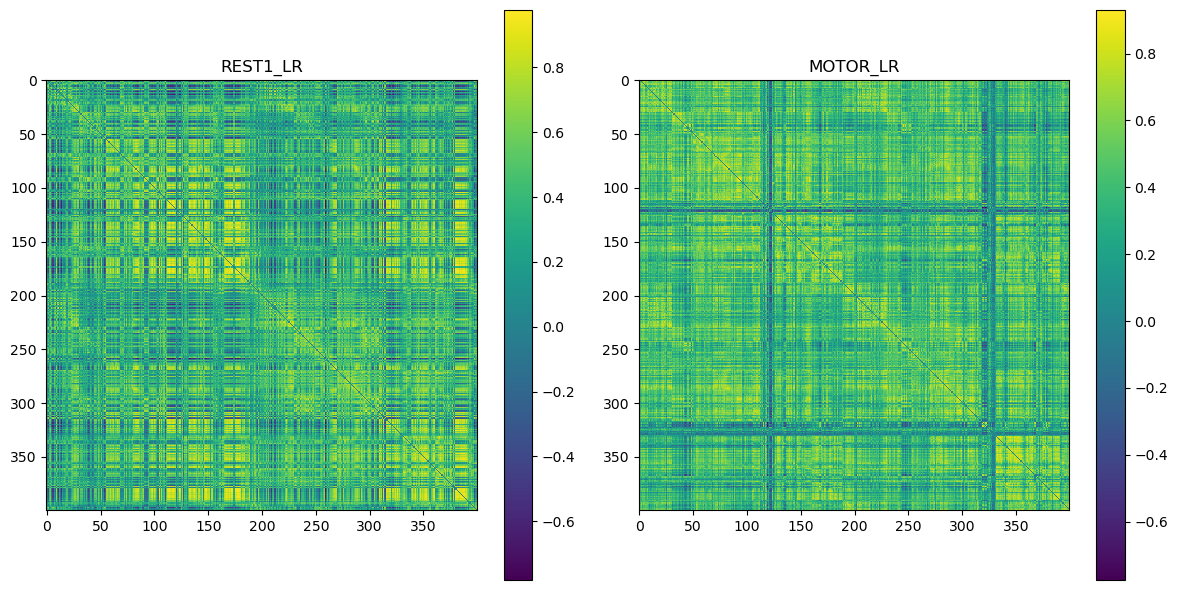

In [8]:
rest_data = np.loadtxt("Data/hcp_rest_and_motor/580751_rfMRI_REST1_LR.csv", delimiter=",", skiprows=1)
motor_data = np.loadtxt("Data/hcp_rest_and_motor/580751_tfMRI_MOTOR_LR.csv", delimiter=",", skiprows=1)

plt.figure(figsize=(12, 6)) 

# Heatmap for 580751_rfMRI_REST1_LR.csv
plt.subplot(1, 2, 1)
plt.imshow(rest_data, cmap='viridis', interpolation='nearest')
plt.title("REST1_LR")
plt.colorbar()

# Heatmap for 580751_rfMRI_MOTOR_LR.csv
plt.subplot(1, 2, 2)
plt.imshow(motor_data, cmap='viridis', interpolation='nearest')
plt.title("MOTOR_LR")
plt.colorbar()

plt.tight_layout()  
plt.show()

In [9]:
# def plot_images(batch):
#     fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
#     for i in range(10):
#         axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
#         axes[i].set_xticks([]); axes[i].set_yticks([])
#     fig.tight_layout(pad=0.1)

# print('Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets')
# plot_images(next(iter(mnist_loader))[0])
# plot_images(next(iter(usps_loader))[0])

## NOT part

In [10]:
import torch.nn as nn

# Transport model T
T = nn.Sequential(
    nn.Conv2d(1, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 1, kernel_size=5, padding=2), 
).to(DEVICE)


# Mapping model f
f = nn.Sequential(
    nn.Conv2d(1, 128, kernel_size=5, padding=2, stride=2),
    nn.ReLU(True),
    nn.AvgPool2d(2),  
    nn.Conv2d(128, 256, kernel_size=5, padding=2, stride=2),
    nn.ReLU(True),
    nn.AvgPool2d(2),  
    nn.Conv2d(256, 512, kernel_size=5, padding=2, stride=2),
    nn.ReLU(True),
    nn.AvgPool2d(2),  
    nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=2),
    nn.ReLU(True),
    nn.AvgPool2d(2),  
    nn.Conv2d(512, 1, kernel_size=1, padding=0),
    nn.Flatten(1),
).to(DEVICE)

T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))


T params: 2055169
f params: 6460417


### STRONG cost

In [11]:
def sq_cost (X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

COST = sq_cost

In [12]:
COST = sq_cost

# Other parameters
T_ITERS = 10
MAX_STEPS = 500 + 1

## NOT algorithm

In [13]:
import warnings
warnings.filterwarnings('ignore')

T.train(True)
f.eval()

for step in tqdm(range(MAX_STEPS)):
    for t_iter in range(T_ITERS):
        X, Y = sample_fMRI_data(train_data_loader)
        X = torch.tensor(X, device=DEVICE)
        T_loss = COST(X, T(X)).mean() - f(T(X)).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()

    # f optimization
    T.eval()
    f.train(True)
    X, Y = sample_fMRI_data(train_data_loader)
    T_X_train = T(torch.tensor(X, device=DEVICE)).to(DEVICE)
    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    f_loss = f(T(X)).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()


In [14]:
# Function to plot original and predicted matrices
def plot_original_and_predicted(original, predicted, title_original, title_predicted):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Original data
    axes[0].set_title(title_original)
    axes[0].imshow(original[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[0].axis('off')

    # Predicted data
    axes[1].set_title(title_predicted)
    axes[1].imshow(predicted[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[1].axis('off')

    plt.show()


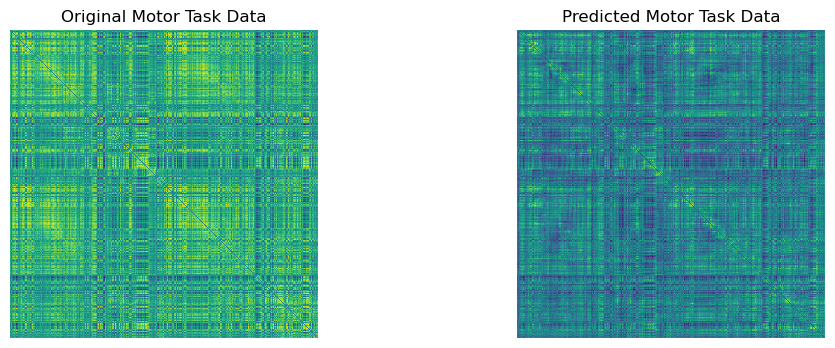

In [16]:
# After your training loop
# Generate predictions for the "motor" task data
X, Y = sample_fMRI_data(test_data_loader)
X = torch.tensor(X, device=DEVICE)
T_X_test = T(X).to(DEVICE)

# Plot the original and predicted "motor" task data
plot_original_and_predicted(X, T_X_test, "Original Motor Task Data", "Predicted Motor Task Data")

In [ ]:
for i in range(651):
    # Generate predictions for the "motor" task data for the current data point
    X, Y = sample_fMRI_data(test_data_loader)
    X = torch.tensor(X, device=DEVICE)
    T_X_test = T(X).to(DEVICE)

    # Plot the original and predicted "motor" task data
    plot_original_and_predicted(X, T_X_test, "Original Motor Task Data", "Predicted Motor Task Data")

In [ ]:
import torch
import torch.nn as nn

# Define BCELoss
BCELoss = nn.BCELoss()

# Initialize variables to accumulate losses and means
total_bce_loss = 0.0
total_mean_motor_sum = torch.zeros(1).to(DEVICE)  # Initialize with zeros

# Initialize a list to store losses and means for each batch
bce_losses = []

# Loop through all batches in the test set
for batch_data in test_data_loader:
    rest_batch = batch_data["rest_fMRI_data"].to(DEVICE)
    motor_batch = batch_data["motor_task_fMRI_data"].to(DEVICE)

    # Assuming T_X_train contains the reconstructions for the current batch
    recon_batch = T(rest_batch)

    # Calculate the BCE loss for the current batch
    bce_loss = BCELoss(recon_batch, motor_batch)

    # Accumulate the losses
    total_bce_loss += bce_loss.item()

    # Store the losses for each batch
    bce_losses.append(bce_loss.item())

    # Calculate the mean of motor for the current batch
    mean_motor = torch.mean(motor_batch, dim=0, keepdim=True).float()

    # Sum the mean_motor tensors across batches
    total_mean_motor_sum += mean_motor

# Calculate the mean BCE loss
mean_bce_loss = total_bce_loss / len(test_data_loader)

# Calculate the mean of the summed mean_motor tensors
mean_mean_motor = total_mean_motor_sum / len(test_data_loader)

print("Mean BCE Loss:", mean_bce_loss)
print("Mean of Mean Motor:", mean_mean_motor.item())  # Convert to scalar
